[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/noobmaster-ru/ml_mipt/blob/main/sem3/main.ipynb)

# Нейронные сети: Autograd

# Нейронные сети: Autograd

## Библиотеки

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !wget -q -O requirements.txt https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem2/requirements.txt
    !pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid


from torchvision import datasets
from torchvision import transforms

## Разбор домашней задачи

Рассмотрим совместное правдоподобие модели и данных:
$$
p\bigr(\mathbf{y}, \mathbf{w}|\mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)p\bigr(\mathbf{w}\bigr),
$$
где для простоты рассмотрим $p\bigr(\mathbf{w}\bigr)=\mathcal{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$.

По принципу максимума правдоподобия получаем следующую функцию для минимизации:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$
Для удобства перепишем в матричном виде:
$$
\beta\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2 + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}=
\beta\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)^{\mathsf{T}}\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)  + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}= \\
=\beta\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{y}\mathbf{X}\mathbf{w} + \beta\mathbf{y}^{\mathsf{T}}\mathbf{y} + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}
$$

Воспользуемся необходимым условием первого порядка:
$$
\frac{\partial}{\partial \mathbf{w}}\left(\beta\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{y}\mathbf{X}\mathbf{w} + \beta\mathbf{y}^{\mathsf{T}}\mathbf{y} + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}\right) = 0 = 2\beta\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{X}^{\mathsf{T}}\mathbf{y} + 2\gamma\mathbf{w} \\
\Rightarrow \hat{\mathbf{w}} = \beta\left(\beta\mathbf{X}^{\mathsf{T}}\mathbf{X} + \gamma\mathbf{I}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{y}
$$

In [3]:
np.random.seed(0)
l = 1000
n = 2

X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [4]:
loo = KFold(10)
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
best_gamma = sorted(gamma_scores,
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False,
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.766


In [6]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-b+ c)/a, -1
    x2, y2 = -(b + c)/a, 1

    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)

    return x_axis, y_axis

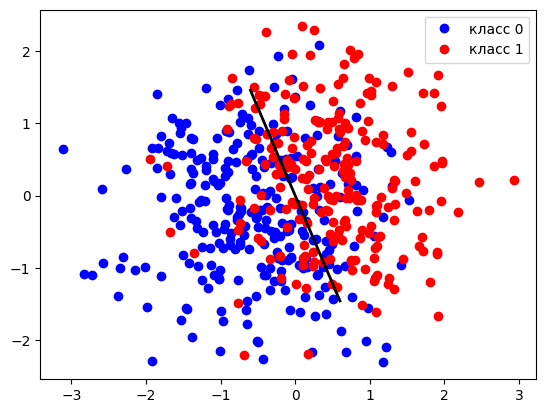

In [7]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o',
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6),
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()

## Автоматическое дифференцирование

### Разбор примера
$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\left(\frac{x_1}{x_2}\right)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$

#### Граф вычислений

![](https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig1.png?raw=1)

#### Дифференцирование вперед
- $\frac{\partial z_1}{\partial x_1} = \frac{1}{x_2}$

- $\frac{\partial z_2}{\partial x_1} = 0$

- $\frac{\partial z_3}{\partial x_1} = \frac{\partial z_3}{\partial z_1}\frac{\partial z_1}{\partial x_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}$

- $\frac{\partial z_4}{\partial x_1} = \frac{\partial z_4}{\partial z_1}\frac{\partial z_1}{\partial x_1} + \frac{\partial z_4}{\partial z_2}\frac{\partial z_2}{\partial x_1} = \frac{1}{x_2}$

- $\frac{\partial z_5}{\partial x_1} = \frac{\partial z_5}{\partial z_3}\frac{\partial z_3}{\partial x_1} + \frac{\partial z_5}{\partial z_4}\frac{\partial z_4}{\partial x_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}$

- $\frac{\partial z_6}{\partial x_1} = \frac{\partial z_6}{\partial z_5}\frac{\partial z_5}{\partial x_1} + \frac{\partial z_6}{\partial x_3}\frac{\partial x_3}{\partial x_1} = x_3\left(-\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\right)$

- $\frac{\partial f}{x_1}= \frac{\partial f}{\partial x_1}\frac{\partial z_6}{\partial x_1} = x_3\left(-\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\right)$

#### Дифференцирование назад
- $\frac{\partial f}{\partial z_6} = 1$

- $\frac{\partial f}{\partial z_5} = \frac{\partial f}{\partial z_6}\frac{\partial z_6}{\partial z_5} = x_3$

- $\frac{\partial f}{\partial z_4} = \frac{\partial f}{\partial z_5}\frac{\partial z_5}{\partial z_4} = x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$

- $\frac{\partial f}{\partial z_3} = \frac{\partial f}{\partial z_5}\frac{\partial z_5}{\partial z_3} = x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)$

- $\frac{\partial f}{\partial z_2} = \frac{\partial f}{\partial z_4}\frac{\partial z_4}{\partial z_2} = x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$

- $\frac{\partial f}{\partial z_1} = \frac{\partial f}{\partial z_3}\frac{\partial z_3}{\partial z_1} + \frac{\partial f}{\partial z_4}\frac{\partial z_4}{\partial z_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) -\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$

- $\frac{\partial f}{\partial x_1} = \frac{\partial f}{\partial z_1}\frac{\partial z_1}{\partial x_1} = -\frac{1}{x_2}\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) -\frac{1}{x_2}\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$

### Плюсы и минусы каждого метода
Дифференцирование вперед:
- использует меньше памяти, чем дифференцирование назад;
- вычислительная сложность зависит от числа параметров.

Дифференцирование назад:
- использует больше памяти, чем дифференцирование вперед;
- вычислительная сложность не зависит от числа параметров.

## MNIST Dataset

In [8]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True,
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:10<00:00, 911kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


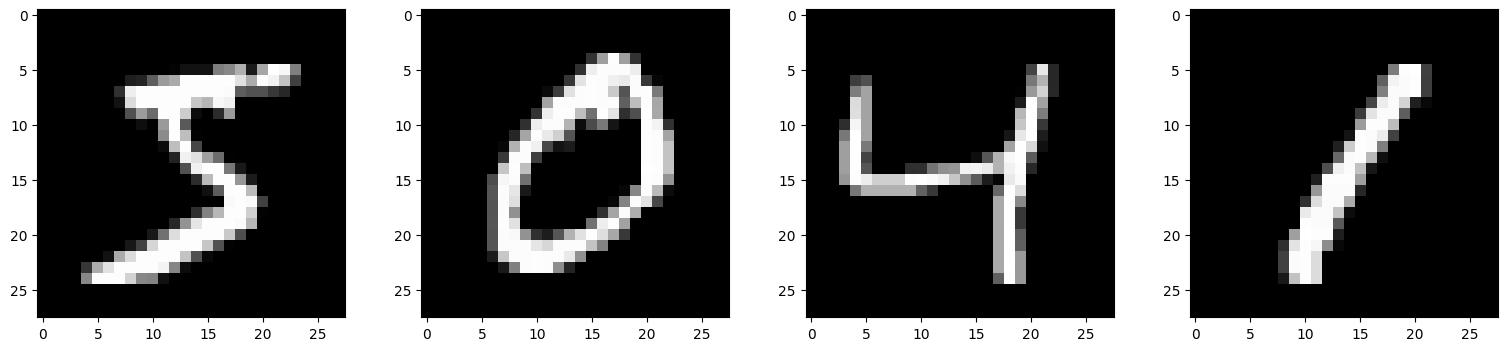

In [9]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')

plt.show()

### Полносвязная нейронная сеть (Персептрон)
![](https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig2.png?raw=1)


Перепишем в матричном виде:
$$
f(\mathbf{x}, \mathbf{W}) = \mathbf{W}_{n_2+1}\sigma\bigr( \cdots\mathbf{W}_2\sigma\bigr(\mathbf{W}_{1}\mathbf{x}\bigr)\cdots\bigr)
$$

В данном примере введены следующие обозначения:
- число $n$ --- размерность пространства признаков (`input_dim`);
- число $n_1$ --- размерность скрытого слоя (`hidden_dim`);
- число $n_2$ --- количество скрытых слоев (`num_layers`);
- число $n_3$ --- размерность пространства ответов (`output_dim`).

Заметим, что при $n_2=0$ получаем линейную модель, то есть линейная модель это частный случай полносвязного персептрона.

P.S. размерность скрытого слоя может зависить от номера слоя, для простоты рассмотрим фиксируемый размер скрытого слоя.

In [10]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=784, num_layers=0,
                 hidden_dim=64, output_dim=10, p=0.0):
        super(Perceptron, self).__init__()

        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim

        self.layers.add_module('classifier',
                               torch.nn.Linear(prev_size, output_dim))

    def forward(self, input):
        return self.layers(input)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model = Perceptron()
model.to(device)

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [13]:
model = Perceptron(num_layers=1)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [14]:
model = Perceptron(num_layers=2)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [15]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in generator:
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [16]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64,
                                                shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [17]:
def draw_table(data, title=['ACCURACY'], width=[60, 11]):
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'

    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

In [18]:
model = Perceptron(num_layers=0)
model.to(device)

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [19]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.07      0.52      0.13       980
           1       0.08      0.02      0.04      1135
           2       0.02      0.00      0.01      1032
           3       0.02      0.02      0.02      1010
           4       0.00      0.00      0.00       982
           5       0.07      0.01      0.02       892
           6       0.10      0.08      0.09       958
           7       0.07      0.00      0.01      1028
           8       0.02      0.01      0.01       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.07     10000
   macro avg       0.05      0.07      0.03     10000
weighted avg       0.05      0.07      0.03     10000



In [20]:
_ = model.train()
trainer(model=model,
        dataset=MNIST_train,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=4)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [21]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.97      0.97      1135
           2       0.90      0.91      0.90      1032
           3       0.92      0.90      0.91      1010
           4       0.94      0.92      0.93       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.86      0.90      0.88       974
           9       0.90      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



#### Гиперпараметры, которые нужно подобрать
- num_layers
- hidden_dim
- lr
- p

Воспользуемся Cross Validation для их подбора.

In [22]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'num_layers': [0, 2],
                      'hidden_dim': [8, 64],
                      'p': [0.3, 0.7],
                      'lr': [0.001]})

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0,1)
Y_train = MNIST_train.targets.data

In [23]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)

        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'])
        model.to(device)
        _ = model.train()
        trainer(model=model,
                dataset=traindata,
                loss_function=torch.nn.CrossEntropyLoss(),
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']),
                epochs=4)

        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [24]:
draw_table(scores)

+------------------------------------------------------------+-----------+
|                                                            |   ACCURACY|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|       0.92|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}|       0.92|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}|       0.84|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}|       0.47|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|       0.92|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 64, 'lr

## Прореживание нейросетей

<img src="https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig3.png?raw=1" alt="drawing" width="400"/>

1 - Произвольное удаление параметров 2 - Optimal Brain Damage
3 - Variational Method               4 - Удаление зависимых признаков

* *Грабовой А.В., Бахтеев О.Ю., Стрижов В.В.* Определение релевантности параметров нейросети // Информатика и ее применения, 2019.
* *Грабовой А.В., Бахтеев О. Ю., Стрижов В.В.* Введение отношения порядка на множестве параметров аппроксимирующих моделей // Информатика и ее применения, 2020.

<img src="https://github.com/andriygav/MachineLearningSeminars/blob/master/sem3/fig4.png?raw=1" alt="drawing" width="400"/>

1 - Произвольное удаление параметров 2 - Optimal Brain Damage
3 - Variational Method               4 - Удаление зависимых признаков